In [1]:
import tensorflow as tf
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import time
from datetime import timedelta
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('data/MNIST',one_hot=False)

Extracting data/MNIST\train-images-idx3-ubyte.gz
Extracting data/MNIST\train-labels-idx1-ubyte.gz
Extracting data/MNIST\t10k-images-idx3-ubyte.gz
Extracting data/MNIST\t10k-labels-idx1-ubyte.gz


In [3]:
initSeed = tf.set_random_seed(420)
gHiddenSize = 30

dFilterSize1 = 5
dFilterShape1 = (dFilterSize1,dFilterSize1)
dNumberOfFilters1 = 32

dFilterSize2 = 5
dFilterShape2 = (dFilterSize1,dFilterSize1)
dNumberOfFilters2 = 64

dStride = (1,1) # y then x
dStrideShape = [1,dStride[0],dStride[1],1] #1s on sides are for image number and channel respectively

dPoolingStride = (2,2)
dPoolingStrideShape = [1,dPoolingStride[0],dPoolingStride[1],1]

dFCSize = 1024


gFilterSize1 = 3
gFilterShape1 = (gFilterSize1,gFilterSize1)
gNumberOfFilters1 = 50

gFilterSize2 = 3
gFilterShape2 = (gFilterSize2,gFilterSize2)
gNumberOfFilters2 = 25

gFilterSize3 = 3

gStride = (2,2) # y then x
gStrideShape = [1,gStride[0],gStride[1],1] #1s on sides are for image number and channel respectively

gPoolingStride = (2,2)
gPoolingStrideShape = [1,gPoolingStride[0],gPoolingStride[1],1]


numberOfChannels = 1 #this is the color depth. greyscale is 1, rgb is 3 etc. What is binary? probably 1
batchSize = 50
imgSize = 784
imgWidth = 28
zSize = 100
digit = 5

In [4]:
trainingImages = np.zeros((1,784),dtype=np.float32)
for i in range(0,mnist.train.images.shape[0]):
    if mnist.train.labels[i] == digit:
        trainingImages = np.concatenate((trainingImages,np.reshape(mnist.train.images[i],(1,784))),axis=0)
trainingImages = np.delete(trainingImages,0,0)

In [5]:
x = tf.placeholder(tf.float32,[None,28,28,1])
z = tf.placeholder(tf.float32,[None,zSize])
g = tf.placeholder(tf.float32,[None,28,28,1])

In [6]:
def weights(nameOfVariable, shapeOfVariable):
    return tf.Variable(tf.truncated_normal(stddev=0.05,shape=shapeOfVariable), name=nameOfVariable)
def biases(nameOfVariable, shapeOfVariable):
    return tf.Variable(tf.truncated_normal(stddev=0.05,shape=shapeOfVariable), name=nameOfVariable)

In [7]:
with tf.name_scope('Generator'): # in [batchSize,zSize] out [batchSize,imageSize]
    gw0 = weights('gw0',[zSize, 3136])
    gw1 = weights('gw1',[gFilterSize1, gFilterSize1, numberOfChannels,gNumberOfFilters1])
    gw2 = weights('gw2',[gFilterSize2, gFilterSize2, gNumberOfFilters1,gNumberOfFilters2])
    gw3 = weights('gw3',[gFilterSize3, gFilterSize3, gNumberOfFilters2,1])

    gb0 = biases('gb0',[3136])
    gb1 = biases('gb1',[gNumberOfFilters1])
    gb2 = biases('gb2',[gNumberOfFilters2])
    gb3 = biases('gb3',[1])
    
    def generator(zNoise):      
        g0 = tf.matmul(zNoise,gw0) + gb0
        g0 = tf.reshape(g0, [-1, 56, 56, 1])
        g0 = tf.nn.relu(g0)
        
        g1 = tf.nn.conv2d(g0,gw1,gStrideShape,'SAME')
        g1 = tf.nn.relu(g1)
        g1 = g1 + gb1
        g1 = tf.image.resize_images(g1, [56,56])
        
        g2 = tf.nn.conv2d(g1,gw2,gStrideShape,'SAME')
        g2 = tf.nn.relu(g2)
        g2 = g2 + gb2
        g2 = tf.image.resize_images(g2, [56,56])
        
        g3 = tf.nn.conv2d(g2,gw3,gStrideShape,'SAME')
        g3 = tf.nn.relu(g3)
        g3 = g3 + gb3
        g3 = tf.nn.sigmoid(g3)
        
        return g3

In [8]:
with tf.name_scope('Discriminator'): # in [batchSize,28,28,1] out [batchSize,1]
    dw0 = weights('dw0', [dFilterSize1,dFilterSize1,numberOfChannels,dNumberOfFilters1])
    dw1 = weights('dw1', [dFilterSize2,dFilterSize2,dNumberOfFilters1,dNumberOfFilters2])
    dw2 = weights('dw2', [3136,dFCSize])
    dw3 = weights('dw3', [dFCSize,1])
    
    db0 = biases('db0', [batchSize,imgWidth,imgWidth,dNumberOfFilters1])
    db1 = biases('db1', [batchSize,int(imgWidth/dPoolingStride[0]),int(imgWidth/dPoolingStride[1]),dNumberOfFilters2])
    db2 = biases('db2', [dFCSize])
    
    def discriminator(inputData):
        d0 = tf.nn.conv2d(inputData,dw0,dStrideShape,'SAME')
        d0 = d0 + db0
        d0 = tf.nn.max_pool(d0,dPoolingStrideShape,dPoolingStrideShape,'SAME')
        d0 = tf.nn.relu(d0)
        
        d1 = tf.nn.conv2d(d0,dw1,dStrideShape,'SAME')
        d1 = d1 + db1
        d1 = tf.nn.max_pool(d1,dPoolingStrideShape,dPoolingStrideShape,'SAME')
        d1 = tf.nn.relu(d1)
        
        num_features = d1.shape[1:4].num_elements()
        d2 = tf.reshape(d1,[-1,(num_features)])
        
        d3 = tf.nn.softplus(tf.add(tf.matmul(d2,dw2),db2))
        d4 = tf.nn.sigmoid(tf.matmul(d3,dw3))
        return d4

In [9]:
sess = tf.Session()
init = tf.global_variables_initializer()

In [10]:
gz = generator(z)
dx = discriminator(x)
dg = discriminator(gz)

In [11]:
gLoss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dg, labels=tf.ones_like(dg)))
dLossOfReal = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dx, labels=tf.ones_like(dx)))
dLossOfFake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dg, labels=tf.zeros_like(dg)))
dLoss = dLossOfReal + dLossOfFake

In [44]:
SGDOptimizer = tf.train.GradientDescentOptimizer(0.0001)
AdamOptimizer = tf.train.AdamOptimizer(0.0001)

trainDReal = SGDOptimizer.minimize(dLossOfReal,var_list=[dw0,dw1,dw2,dw3,db0,db1,db2])
trainDFake = SGDOptimizer.minimize(dLossOfFake,var_list=[dw0,dw1,dw2,dw3,db0,db1,db2])
trainD = SGDOptimizer.minimize(dLoss,var_list=[dw0,dw1,dw2,dw3,db0,db1,db2])
trainG = SGDOptimizer.minimize(gLoss,var_list=[gw0,gw1,gw2,gw3,gb0,gb1,gb2,gb3])

In [45]:
def newXBatch(size):
    xBatch = np.zeros((1,28,28,1),dtype=np.float32)
    while xBatch.shape[0] != size + 1:
        xBatch = np.concatenate((xBatch,trainingImages[random.randint(0,len(trainingImages)-1)].reshape(1,28,28,1)),axis=0)    
    xBatch = np.delete(xBatch,0,0)
    return xBatch #Not good

def newZBatch(size):
    return sess.run(tf.random_normal(shape=[size,zSize],seed=initSeed))

def newGBatch(size):
    return sess.run(generator(z,size),{z:newZBatch(size)})

In [46]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
#saver.restore(sess, 'C:\Preston\MNIST GAN\mnistGAN')

In [ ]:
startTime = time.time()
for i in range(0,50000):
    currentDLossOfReal = sess.run(dLossOfReal,{z:newZBatch(batchSize),x:newXBatch(batchSize)})
    currentDLossOfFake = sess.run(dLossOfFake,{z:newZBatch(batchSize),x:newXBatch(batchSize)})
    averageDLoss = (currentDLossOfReal + currentDLossOfFake) / 2
    currentGLoss = sess.run(gLoss,{z:newZBatch(batchSize)})
    trainingSchedule = round((i/25)%2)

    if currentDLossOfReal > 0.4:
        sess.run(trainDReal,{x:newXBatch(batchSize)})
    if currentDLossOfFake > 0.75:
        sess.run(trainDFake,{z:newZBatch(batchSize)})
    if currentGLoss > 0.4:
        sess.run(trainG,{z:newZBatch(batchSize)})
    
    if i % 1 == 0:
        print('Iteration:',i,'gLoss:',currentGLoss, 'averageDLoss',averageDLoss,'dLossOfReal:',currentDLossOfReal,'dLossOfFake:',currentDLossOfFake,'Time Elapsed:',timedelta(seconds=int(round(time.time()-startTime))))

Iteration: 0 gLoss: 0.551915 averageDLoss 0.705098927021 dLossOfReal: 0.552513 dLossOfFake: 0.857685 Time Elapsed: 0:00:06
Iteration: 1 gLoss: 0.552097 averageDLoss 0.704173564911 dLossOfReal: 0.550909 dLossOfFake: 0.857438 Time Elapsed: 0:00:13
Iteration: 2 gLoss: 0.552284 averageDLoss 0.705464363098 dLossOfReal: 0.553746 dLossOfFake: 0.857183 Time Elapsed: 0:00:20
Iteration: 3 gLoss: 0.552469 averageDLoss 0.705132842064 dLossOfReal: 0.553336 dLossOfFake: 0.85693 Time Elapsed: 0:00:26
Iteration: 4 gLoss: 0.552655 averageDLoss 0.705453813076 dLossOfReal: 0.554226 dLossOfFake: 0.856682 Time Elapsed: 0:00:32
Iteration: 5 gLoss: 0.552839 averageDLoss 0.705003857613 dLossOfReal: 0.553577 dLossOfFake: 0.85643 Time Elapsed: 0:00:39
Iteration: 6 gLoss: 0.553023 averageDLoss 0.705631017685 dLossOfReal: 0.555077 dLossOfFake: 0.856185 Time Elapsed: 0:00:45
Iteration: 7 gLoss: 0.553203 averageDLoss 0.704388380051 dLossOfReal: 0.55284 dLossOfFake: 0.855937 Time Elapsed: 0:00:51
Iteration: 8 gLoss:

Iteration: 67 gLoss: 0.563293 averageDLoss 0.703399896622 dLossOfReal: 0.564363 dLossOfFake: 0.842437 Time Elapsed: 0:07:15
Iteration: 68 gLoss: 0.563449 averageDLoss 0.70305287838 dLossOfReal: 0.563874 dLossOfFake: 0.842231 Time Elapsed: 0:07:21
Iteration: 69 gLoss: 0.563604 averageDLoss 0.702597618103 dLossOfReal: 0.563169 dLossOfFake: 0.842026 Time Elapsed: 0:07:27
Iteration: 70 gLoss: 0.563763 averageDLoss 0.702304065228 dLossOfReal: 0.56279 dLossOfFake: 0.841818 Time Elapsed: 0:07:34
Iteration: 71 gLoss: 0.563915 averageDLoss 0.702147245407 dLossOfReal: 0.56268 dLossOfFake: 0.841614 Time Elapsed: 0:07:40
Iteration: 72 gLoss: 0.564068 averageDLoss 0.702714264393 dLossOfReal: 0.564014 dLossOfFake: 0.841415 Time Elapsed: 0:07:47
Iteration: 73 gLoss: 0.564221 averageDLoss 0.702876806259 dLossOfReal: 0.564541 dLossOfFake: 0.841213 Time Elapsed: 0:07:53
Iteration: 74 gLoss: 0.564372 averageDLoss 0.70212829113 dLossOfReal: 0.563242 dLossOfFake: 0.841015 Time Elapsed: 0:08:00
Iteration: 7

Iteration: 134 gLoss: 0.572808 averageDLoss 0.700976490974 dLossOfReal: 0.571958 dLossOfFake: 0.829995 Time Elapsed: 0:14:34
Iteration: 135 gLoss: 0.572937 averageDLoss 0.700274169445 dLossOfReal: 0.570721 dLossOfFake: 0.829827 Time Elapsed: 0:14:41
Iteration: 136 gLoss: 0.573061 averageDLoss 0.700868487358 dLossOfReal: 0.572074 dLossOfFake: 0.829663 Time Elapsed: 0:14:48
Iteration: 137 gLoss: 0.573193 averageDLoss 0.700959503651 dLossOfReal: 0.572422 dLossOfFake: 0.829497 Time Elapsed: 0:14:55
Iteration: 138 gLoss: 0.573322 averageDLoss 0.701235175133 dLossOfReal: 0.573141 dLossOfFake: 0.829329 Time Elapsed: 0:15:01
Iteration: 139 gLoss: 0.573452 averageDLoss 0.700718283653 dLossOfReal: 0.572271 dLossOfFake: 0.829165 Time Elapsed: 0:15:08
Iteration: 140 gLoss: 0.573578 averageDLoss 0.699736237526 dLossOfReal: 0.570474 dLossOfFake: 0.828999 Time Elapsed: 0:15:15
Iteration: 141 gLoss: 0.573706 averageDLoss 0.699930906296 dLossOfReal: 0.571028 dLossOfFake: 0.828833 Time Elapsed: 0:15:21


Iteration: 200 gLoss: 0.580667 averageDLoss 0.699369311333 dLossOfReal: 0.578817 dLossOfFake: 0.819922 Time Elapsed: 0:22:09
Iteration: 201 gLoss: 0.580776 averageDLoss 0.699511945248 dLossOfReal: 0.579242 dLossOfFake: 0.819782 Time Elapsed: 0:22:16
Iteration: 202 gLoss: 0.580887 averageDLoss 0.699481964111 dLossOfReal: 0.57932 dLossOfFake: 0.819643 Time Elapsed: 0:22:23
Iteration: 203 gLoss: 0.580996 averageDLoss 0.699162065983 dLossOfReal: 0.578821 dLossOfFake: 0.819503 Time Elapsed: 0:22:30
Iteration: 204 gLoss: 0.581104 averageDLoss 0.699328839779 dLossOfReal: 0.579293 dLossOfFake: 0.819365 Time Elapsed: 0:22:37
Iteration: 205 gLoss: 0.581212 averageDLoss 0.698702573776 dLossOfReal: 0.578176 dLossOfFake: 0.819229 Time Elapsed: 0:22:44
Iteration: 206 gLoss: 0.581319 averageDLoss 0.699577450752 dLossOfReal: 0.580063 dLossOfFake: 0.819092 Time Elapsed: 0:22:51
Iteration: 207 gLoss: 0.581429 averageDLoss 0.698970198631 dLossOfReal: 0.578984 dLossOfFake: 0.818956 Time Elapsed: 0:22:58
I

Iteration: 266 gLoss: 0.587341 averageDLoss 0.698195397854 dLossOfReal: 0.584886 dLossOfFake: 0.811504 Time Elapsed: 0:29:58
Iteration: 267 gLoss: 0.587434 averageDLoss 0.697487592697 dLossOfReal: 0.583588 dLossOfFake: 0.811387 Time Elapsed: 0:30:05
Iteration: 268 gLoss: 0.587527 averageDLoss 0.698458313942 dLossOfReal: 0.585646 dLossOfFake: 0.811271 Time Elapsed: 0:30:13
Iteration: 269 gLoss: 0.58762 averageDLoss 0.697814166546 dLossOfReal: 0.584473 dLossOfFake: 0.811155 Time Elapsed: 0:30:20
Iteration: 270 gLoss: 0.587715 averageDLoss 0.697291493416 dLossOfReal: 0.583546 dLossOfFake: 0.811037 Time Elapsed: 0:30:28
Iteration: 271 gLoss: 0.587805 averageDLoss 0.697968482971 dLossOfReal: 0.585013 dLossOfFake: 0.810924 Time Elapsed: 0:30:35
Iteration: 272 gLoss: 0.587897 averageDLoss 0.698017001152 dLossOfReal: 0.585226 dLossOfFake: 0.810808 Time Elapsed: 0:30:42
Iteration: 273 gLoss: 0.587988 averageDLoss 0.698141813278 dLossOfReal: 0.585588 dLossOfFake: 0.810696 Time Elapsed: 0:30:50
I

Iteration: 332 gLoss: 0.593031 averageDLoss 0.697213292122 dLossOfReal: 0.589998 dLossOfFake: 0.804428 Time Elapsed: 0:38:03
Iteration: 333 gLoss: 0.593113 averageDLoss 0.697308778763 dLossOfReal: 0.590288 dLossOfFake: 0.80433 Time Elapsed: 0:38:11
Iteration: 334 gLoss: 0.59319 averageDLoss 0.697020292282 dLossOfReal: 0.589809 dLossOfFake: 0.804232 Time Elapsed: 0:38:18
Iteration: 335 gLoss: 0.593268 averageDLoss 0.696928918362 dLossOfReal: 0.589721 dLossOfFake: 0.804137 Time Elapsed: 0:38:25
Iteration: 336 gLoss: 0.593348 averageDLoss 0.696630239487 dLossOfReal: 0.589223 dLossOfFake: 0.804038 Time Elapsed: 0:38:33
Iteration: 337 gLoss: 0.593425 averageDLoss 0.697405099869 dLossOfReal: 0.590867 dLossOfFake: 0.803943 Time Elapsed: 0:38:40
Iteration: 338 gLoss: 0.593501 averageDLoss 0.697410225868 dLossOfReal: 0.590974 dLossOfFake: 0.803847 Time Elapsed: 0:38:48
Iteration: 339 gLoss: 0.593579 averageDLoss 0.697085618973 dLossOfReal: 0.59042 dLossOfFake: 0.803751 Time Elapsed: 0:38:55
Ite

Iteration: 398 gLoss: 0.597916 averageDLoss 0.69612288475 dLossOfReal: 0.593821 dLossOfFake: 0.798424 Time Elapsed: 0:46:27
Iteration: 399 gLoss: 0.597984 averageDLoss 0.695808887482 dLossOfReal: 0.593276 dLossOfFake: 0.798342 Time Elapsed: 0:46:35
Iteration: 400 gLoss: 0.598054 averageDLoss 0.695989847183 dLossOfReal: 0.593724 dLossOfFake: 0.798256 Time Elapsed: 0:46:43
Iteration: 401 gLoss: 0.598121 averageDLoss 0.69655328989 dLossOfReal: 0.594933 dLossOfFake: 0.798173 Time Elapsed: 0:46:50
Iteration: 402 gLoss: 0.59819 averageDLoss 0.695908784866 dLossOfReal: 0.593728 dLossOfFake: 0.798089 Time Elapsed: 0:46:58
Iteration: 403 gLoss: 0.598259 averageDLoss 0.695309281349 dLossOfReal: 0.592613 dLossOfFake: 0.798006 Time Elapsed: 0:47:06
Iteration: 404 gLoss: 0.598333 averageDLoss 0.695792257786 dLossOfReal: 0.593668 dLossOfFake: 0.797917 Time Elapsed: 0:47:14
Iteration: 405 gLoss: 0.598402 averageDLoss 0.695932149887 dLossOfReal: 0.594031 dLossOfFake: 0.797833 Time Elapsed: 0:47:21
Ite

Iteration: 464 gLoss: 0.602158 averageDLoss 0.69529402256 dLossOfReal: 0.597324 dLossOfFake: 0.793264 Time Elapsed: 0:55:01
Iteration: 465 gLoss: 0.602219 averageDLoss 0.695033311844 dLossOfReal: 0.596878 dLossOfFake: 0.793189 Time Elapsed: 0:55:09
Iteration: 466 gLoss: 0.60228 averageDLoss 0.695011973381 dLossOfReal: 0.596905 dLossOfFake: 0.793119 Time Elapsed: 0:55:16
Iteration: 467 gLoss: 0.602338 averageDLoss 0.69519007206 dLossOfReal: 0.597334 dLossOfFake: 0.793046 Time Elapsed: 0:55:24
Iteration: 468 gLoss: 0.602395 averageDLoss 0.695547521114 dLossOfReal: 0.598119 dLossOfFake: 0.792976 Time Elapsed: 0:55:32
Iteration: 469 gLoss: 0.602457 averageDLoss 0.695203900337 dLossOfReal: 0.597506 dLossOfFake: 0.792901 Time Elapsed: 0:55:40
Iteration: 470 gLoss: 0.602517 averageDLoss 0.695641040802 dLossOfReal: 0.598452 dLossOfFake: 0.79283 Time Elapsed: 0:55:48
Iteration: 471 gLoss: 0.602573 averageDLoss 0.69461786747 dLossOfReal: 0.596473 dLossOfFake: 0.792762 Time Elapsed: 0:55:55
Itera

Iteration: 530 gLoss: 0.605847 averageDLoss 0.695145606995 dLossOfReal: 0.601477 dLossOfFake: 0.788814 Time Elapsed: 1:03:50
Iteration: 531 gLoss: 0.6059 averageDLoss 0.694745481014 dLossOfReal: 0.600738 dLossOfFake: 0.788753 Time Elapsed: 1:03:58
Iteration: 532 gLoss: 0.605952 averageDLoss 0.694909930229 dLossOfReal: 0.60113 dLossOfFake: 0.78869 Time Elapsed: 1:04:06
Iteration: 533 gLoss: 0.606002 averageDLoss 0.694788455963 dLossOfReal: 0.600948 dLossOfFake: 0.788629 Time Elapsed: 1:04:15
Iteration: 534 gLoss: 0.606054 averageDLoss 0.694536089897 dLossOfReal: 0.600502 dLossOfFake: 0.78857 Time Elapsed: 1:04:23
Iteration: 535 gLoss: 0.606104 averageDLoss 0.695360422134 dLossOfReal: 0.602213 dLossOfFake: 0.788508 Time Elapsed: 1:04:31
Iteration: 536 gLoss: 0.606155 averageDLoss 0.694482386112 dLossOfReal: 0.600518 dLossOfFake: 0.788447 Time Elapsed: 1:04:39
Iteration: 537 gLoss: 0.606206 averageDLoss 0.695065617561 dLossOfReal: 0.601745 dLossOfFake: 0.788386 Time Elapsed: 1:04:48
Itera

Iteration: 596 gLoss: 0.609061 averageDLoss 0.694547235966 dLossOfReal: 0.604123 dLossOfFake: 0.784972 Time Elapsed: 1:13:06
Iteration: 597 gLoss: 0.609106 averageDLoss 0.693986177444 dLossOfReal: 0.603059 dLossOfFake: 0.784914 Time Elapsed: 1:13:14
Iteration: 598 gLoss: 0.609153 averageDLoss 0.694584012032 dLossOfReal: 0.604311 dLossOfFake: 0.784857 Time Elapsed: 1:13:23
Iteration: 599 gLoss: 0.609199 averageDLoss 0.694326400757 dLossOfReal: 0.603845 dLossOfFake: 0.784807 Time Elapsed: 1:13:31
Iteration: 600 gLoss: 0.609244 averageDLoss 0.695006608963 dLossOfReal: 0.605263 dLossOfFake: 0.78475 Time Elapsed: 1:13:39
Iteration: 601 gLoss: 0.609292 averageDLoss 0.694573521614 dLossOfReal: 0.604452 dLossOfFake: 0.784695 Time Elapsed: 1:13:48
Iteration: 602 gLoss: 0.609337 averageDLoss 0.694310069084 dLossOfReal: 0.603977 dLossOfFake: 0.784643 Time Elapsed: 1:13:56
Iteration: 603 gLoss: 0.60938 averageDLoss 0.693917632103 dLossOfReal: 0.603246 dLossOfFake: 0.784589 Time Elapsed: 1:14:05
It

Iteration: 662 gLoss: 0.611884 averageDLoss 0.69406080246 dLossOfReal: 0.606509 dLossOfFake: 0.781612 Time Elapsed: 1:22:37
Iteration: 663 gLoss: 0.611923 averageDLoss 0.693541765213 dLossOfReal: 0.605516 dLossOfFake: 0.781567 Time Elapsed: 1:22:46
Iteration: 664 gLoss: 0.611962 averageDLoss 0.69350028038 dLossOfReal: 0.605481 dLossOfFake: 0.78152 Time Elapsed: 1:22:54
Iteration: 665 gLoss: 0.612003 averageDLoss 0.69334512949 dLossOfReal: 0.605219 dLossOfFake: 0.781471 Time Elapsed: 1:23:03
Iteration: 666 gLoss: 0.612044 averageDLoss 0.693602323532 dLossOfReal: 0.60578 dLossOfFake: 0.781425 Time Elapsed: 1:23:12
Iteration: 667 gLoss: 0.612083 averageDLoss 0.6936429739 dLossOfReal: 0.605908 dLossOfFake: 0.781378 Time Elapsed: 1:23:21
Iteration: 668 gLoss: 0.612121 averageDLoss 0.694463014603 dLossOfReal: 0.607595 dLossOfFake: 0.781332 Time Elapsed: 1:23:30
Iteration: 669 gLoss: 0.612157 averageDLoss 0.693825721741 dLossOfReal: 0.606363 dLossOfFake: 0.781288 Time Elapsed: 1:23:38
Iterati

Iteration: 728 gLoss: 0.614375 averageDLoss 0.693333029747 dLossOfReal: 0.607997 dLossOfFake: 0.778669 Time Elapsed: 1:32:23
Iteration: 729 gLoss: 0.614411 averageDLoss 0.693466424942 dLossOfReal: 0.608305 dLossOfFake: 0.778628 Time Elapsed: 1:32:32
Iteration: 730 gLoss: 0.614448 averageDLoss 0.693053364754 dLossOfReal: 0.607522 dLossOfFake: 0.778585 Time Elapsed: 1:32:41
Iteration: 731 gLoss: 0.614483 averageDLoss 0.693187236786 dLossOfReal: 0.607832 dLossOfFake: 0.778543 Time Elapsed: 1:32:49
Iteration: 732 gLoss: 0.614515 averageDLoss 0.693102478981 dLossOfReal: 0.607702 dLossOfFake: 0.778503 Time Elapsed: 1:32:58
Iteration: 733 gLoss: 0.614551 averageDLoss 0.693296551704 dLossOfReal: 0.608129 dLossOfFake: 0.778464 Time Elapsed: 1:33:07
Iteration: 734 gLoss: 0.614589 averageDLoss 0.693383574486 dLossOfReal: 0.608347 dLossOfFake: 0.77842 Time Elapsed: 1:33:16
Iteration: 735 gLoss: 0.614622 averageDLoss 0.693167448044 dLossOfReal: 0.607957 dLossOfFake: 0.778378 Time Elapsed: 1:33:26


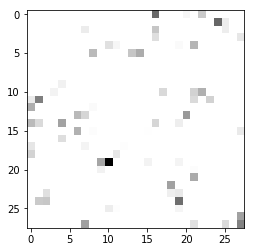

In [55]:
zNoise = newZBatch(1)
newImage = sess.run(generator(z),{z:zNoise})
#print(newImage.shape)
newImage = newImage.reshape(28,28)
plt.imshow(newImage,cmap='binary')

In [56]:
print(sess.run(discriminator(x),{x:newXBatch(batchSize)}))
print(sess.run(discriminator(generator(z)),{z:newZBatch(batchSize)}))

[[ 0.30575073]
 [ 0.29419795]
 [ 0.3069216 ]
 [ 0.29575095]
 [ 0.31150776]
 [ 0.3125132 ]
 [ 0.29613104]
 [ 0.30172464]
 [ 0.29462576]
 [ 0.30902877]
 [ 0.31142461]
 [ 0.29888433]
 [ 0.33120787]
 [ 0.30537266]
 [ 0.29893464]
 [ 0.2985239 ]
 [ 0.30552992]
 [ 0.31033278]
 [ 0.28881609]
 [ 0.33789101]
 [ 0.31463072]
 [ 0.30034533]
 [ 0.31149659]
 [ 0.33450598]
 [ 0.31559822]
 [ 0.28027785]
 [ 0.29343262]
 [ 0.30685645]
 [ 0.31047323]
 [ 0.31032825]
 [ 0.29821661]
 [ 0.31114647]
 [ 0.32596108]
 [ 0.31017369]
 [ 0.331117  ]
 [ 0.32217744]
 [ 0.31732753]
 [ 0.2825987 ]
 [ 0.3253459 ]
 [ 0.31300032]
 [ 0.31923115]
 [ 0.31595457]
 [ 0.28602162]
 [ 0.28436086]
 [ 0.29468486]
 [ 0.3252748 ]
 [ 0.2953378 ]
 [ 0.29643723]
 [ 0.28048572]
 [ 0.28844455]]
[[ 0.31744763]
 [ 0.28927538]
 [ 0.32738367]
 [ 0.30505207]
 [ 0.3042013 ]
 [ 0.3098726 ]
 [ 0.29750887]
 [ 0.30298284]
 [ 0.31581447]
 [ 0.30496174]
 [ 0.31688878]
 [ 0.30536461]
 [ 0.31470212]
 [ 0.30789131]
 [ 0.29415703]
 [ 0.29031095]
 [ 0.3054

In [ ]:
firstGB0 = sess.run(gb0)
for i in range(0,50):
    sess.run(trainG,{z:newZBatch(batchSize)})
print(sess.run(gb0) - firstGB0)

In [ ]:
firstGB0 = sess.run(gb0)
for i in range(0,50):
    sess.run(trainDFake,{z:newZBatch(batchSize)})
print(sess.run(gb0) - firstGB0)

In [ ]:
saver.save(sess,'C:\Preston\MNIST GAN')